In [1]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler

In [22]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [10]:
def apply_z_score_normalization_except_profile_id(df):
    # Separate the column 'profile_id'
    profile_id = df['profile_id']
    
    # Select all columns except 'profile_id' for scaling
    df_to_scale = df.drop('profile_id', axis=1)

    # Creating a StandardScaler object
    scaler = StandardScaler()

    # Fitting the scaler to the data and transforming it
    df_scaled = scaler.fit_transform(df_to_scale)

    # Creating a new DataFrame with the scaled data
    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    # Adding the 'profile_id' column back to the scaled DataFrame
    df_scaled['profile_id'] = profile_id

    return df_scaled

In [27]:
import pandas as pd

def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    """
    Adds multiple exponentially weighted average columns for each original numeric column in the DataFrame 
    for each span value, grouped by 'profile_id'. New features are created only for the original columns.

    :param df: The DataFrame to which the EWA columns will be added.
    :param spans: A list of span values for the EWA calculation.
    :param exclude_columns: A list of column names to be excluded from the EWA calculation.
    :return: DataFrame with new EWA columns added for each span and each original numeric column.
    """
    # Ensure 'profile_id' is not in the exclude_columns
    exclude_columns = set(exclude_columns) | {'profile_id'}

    # List of original columns to apply EWA
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            # Define the column name for the EWA feature
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df


In [28]:
exclude_columns = ['pm']

In [29]:
spans= [600, 1200, 2400, 4800]

In [30]:
df_span = add_ewa_features_by_profile_id(df, spans, exclude_columns)

In [31]:
df_span.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,stator_yoke_ewa_2400,stator_yoke_ewa_4800,ambient_ewa_600,ambient_ewa_1200,ambient_ewa_2400,ambient_ewa_4800,torque_ewa_600,torque_ewa_1200,torque_ewa_2400,torque_ewa_4800
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,...,18.316547,18.316547,19.850691,19.850691,19.850691,19.850691,0.187101,0.187101,0.187101,0.187101
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,...,18.316546,18.316547,19.850691,19.850691,19.850691,19.850691,0.187295,0.187198,0.187149,0.187125
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,...,18.316554,18.316551,19.850691,19.850691,19.850691,19.850691,0.187259,0.187180,0.187141,0.187121
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,...,18.316566,18.316557,19.850691,19.850691,19.850691,19.850691,0.187429,0.187265,0.187183,0.187142
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,...,18.316575,18.316561,19.850690,19.850691,19.850691,19.850691,0.187498,0.187300,0.187201,0.187151


In [32]:
df_span.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id', 'u_q_ewa_600', 'u_q_ewa_1200', 'u_q_ewa_2400',
       'u_q_ewa_4800', 'coolant_ewa_600', 'coolant_ewa_1200',
       'coolant_ewa_2400', 'coolant_ewa_4800', 'stator_winding_ewa_600',
       'stator_winding_ewa_1200', 'stator_winding_ewa_2400',
       'stator_winding_ewa_4800', 'u_d_ewa_600', 'u_d_ewa_1200',
       'u_d_ewa_2400', 'u_d_ewa_4800', 'stator_tooth_ewa_600',
       'stator_tooth_ewa_1200', 'stator_tooth_ewa_2400',
       'stator_tooth_ewa_4800', 'motor_speed_ewa_600', 'motor_speed_ewa_1200',
       'motor_speed_ewa_2400', 'motor_speed_ewa_4800', 'i_d_ewa_600',
       'i_d_ewa_1200', 'i_d_ewa_2400', 'i_d_ewa_4800', 'i_q_ewa_600',
       'i_q_ewa_1200', 'i_q_ewa_2400', 'i_q_ewa_4800', 'stator_yoke_ewa_600',
       'stator_yoke_ewa_1200', 'stator_yoke_ewa_2400', 'stator_yoke_ewa_4800',
       'ambient_ewa_600', 'ambi

In [33]:
df_norm = apply_z_score_normalization_except_profile_id(df_span)

In [34]:
df_norm.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,stator_yoke_ewa_4800,ambient_ewa_600,ambient_ewa_1200,ambient_ewa_2400,ambient_ewa_4800,torque_ewa_600,torque_ewa_1200,torque_ewa_2400,torque_ewa_4800,profile_id
0,-1.238979,-0.799812,-1.648158,0.392820,-1.681117,-1.184128,1.058337,-0.405855,-1.786837,-1.494244,...,-1.591997,-2.452978,-2.433786,-2.395423,-2.325320,-0.477593,-0.513204,-0.556474,-0.610569,17
1,-1.236150,-0.799197,-1.647959,0.393521,-1.681047,-1.184129,1.058278,-0.405867,-1.787686,-1.494323,...,-1.591997,-2.452978,-2.433786,-2.395423,-2.325320,-0.477590,-0.513202,-0.556473,-0.610569,17
2,-1.238757,-0.798729,-1.648064,0.392464,-1.681078,-1.184128,1.058289,-0.405854,-1.787338,-1.493755,...,-1.591997,-2.452978,-2.433786,-2.395423,-2.325320,-0.477590,-0.513203,-0.556473,-0.610569,17
3,-1.236180,-0.798417,-1.648285,0.393356,-1.681146,-1.184126,1.058270,-0.405836,-1.786847,-1.493529,...,-1.591996,-2.452978,-2.433786,-2.395423,-2.325321,-0.477587,-0.513201,-0.556472,-0.610568,17
4,-1.239442,-0.797432,-1.648303,0.393101,-1.681195,-1.184127,1.057279,-0.405455,-1.786248,-1.493738,...,-1.591996,-2.452978,-2.433787,-2.395423,-2.325321,-0.477586,-0.513201,-0.556472,-0.610568,17


In [35]:
window_size = 40  # Adjust the window size as needed

In [36]:
#function to trim sessions to an appropriate size
def preprocess(df, sessions_id, seq_len):
    target="pm"
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]

        #because the sequences based on the profile_id are not all the same lenghts, it takes the longest number of 
        #timestamps that is divisible for the seq_len that will be passed to our model

        #for each sequences we will lost a little bit of the dataset ( no more than the sequence_length = 100)
        r = len(s) % seq_len
        l = len(s) - r
        
        session = s.iloc[:l]
        
        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)
        
        X = torch.from_numpy(X.values).float() 
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))
        
    return sessions

In [37]:
#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(h_size * 2, out_size)
             
    def forward(self, x):
        #init. states 
        h0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        c0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out 

In [41]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100
# ids = [4, 6, 10, 11, 20, 27, 29, 30, 31,32, 36] + [i+41 for i in range(35)]

ids = [20, 6, 65, 18, 66, 13, 27, 4, 58, 56, 53, 79, 44, 70, 62, 30, 80, 74, 68, 36, 76, 48, 12, 29, 32, 16, 9, 2, 3, 8, 14, 15, 81, 21, 45, 42, 73, 41, 63, 26, 17, 31, 69]
sessions = preprocess(df_norm, ids, seq_len)
print(sessions)

#create an lstm instance
model = NET(55, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

[(tensor([[-1.2456, -0.8172, -1.6449,  ..., -0.4990, -0.5409, -0.5929],
        [-1.2445, -0.8171, -1.6442,  ..., -0.4990, -0.5409, -0.5929],
        [-1.2481, -0.8168, -1.6431,  ..., -0.4990, -0.5409, -0.5929],
        ...,
        [-0.0533, -0.9142,  0.5979,  ...,  1.1543,  1.1915,  1.0876],
        [-0.0530, -0.9152,  0.5996,  ...,  1.1543,  1.1916,  1.0877],
        [-0.0550, -0.9139,  0.6033,  ...,  1.1543,  1.1917,  1.0879]]), tensor([-1.8397, -1.8390, -1.8392,  ...,  1.1695,  1.1690,  1.1688])), (tensor([[-1.1846, -0.8728, -1.6475,  ...,  0.1775,  0.2013,  0.2457],
        [-1.1824, -0.8721, -1.6480,  ...,  0.1775,  0.2013,  0.2457],
        [-1.1808, -0.8717, -1.6485,  ...,  0.1776,  0.2013,  0.2457],
        ...,
        [-0.6623, -0.8101, -1.3390,  ...,  0.3499,  0.4022,  0.3204],
        [-0.6623, -0.8093, -1.3388,  ...,  0.3499,  0.4022,  0.3205],
        [-0.6623, -0.8083, -1.3392,  ...,  0.3499,  0.4022,  0.3206]]), tensor([-1.7971, -1.7973, -1.7973,  ..., -0.5306, -0.530

Epoch [1/50], Loss: 0.0064
Epoch [2/50], Loss: 0.0060
Epoch [3/50], Loss: 0.0055
Epoch [4/50], Loss: 0.0048
Epoch [5/50], Loss: 0.0058
Epoch [6/50], Loss: 0.0050
Epoch [7/50], Loss: 0.0061
Epoch [8/50], Loss: 0.0043
Epoch [9/50], Loss: 0.0045
Epoch [10/50], Loss: 0.0046
Epoch [11/50], Loss: 0.0043
Epoch [12/50], Loss: 0.0066
Epoch [13/50], Loss: 0.0055
Epoch [14/50], Loss: 0.0047
Epoch [15/50], Loss: 0.0036
Epoch [16/50], Loss: 0.0044
Epoch [17/50], Loss: 0.0043
Epoch [18/50], Loss: 0.0036
Epoch [19/50], Loss: 0.0035
Epoch [20/50], Loss: 0.0054
Epoch [21/50], Loss: 0.0063
Epoch [22/50], Loss: 0.0058
Epoch [23/50], Loss: 0.0060
Epoch [24/50], Loss: 0.0055
Epoch [25/50], Loss: 0.0034
Epoch [26/50], Loss: 0.0031
Epoch [27/50], Loss: 0.0027
Epoch [28/50], Loss: 0.0056
Epoch [29/50], Loss: 0.0035
Epoch [30/50], Loss: 0.0031
Epoch [31/50], Loss: 0.0033
Epoch [32/50], Loss: 0.0043
Epoch [33/50], Loss: 0.0034
Epoch [34/50], Loss: 0.0043
Epoch [35/50], Loss: 0.0053
Epoch [36/50], Loss: 0.0038
E

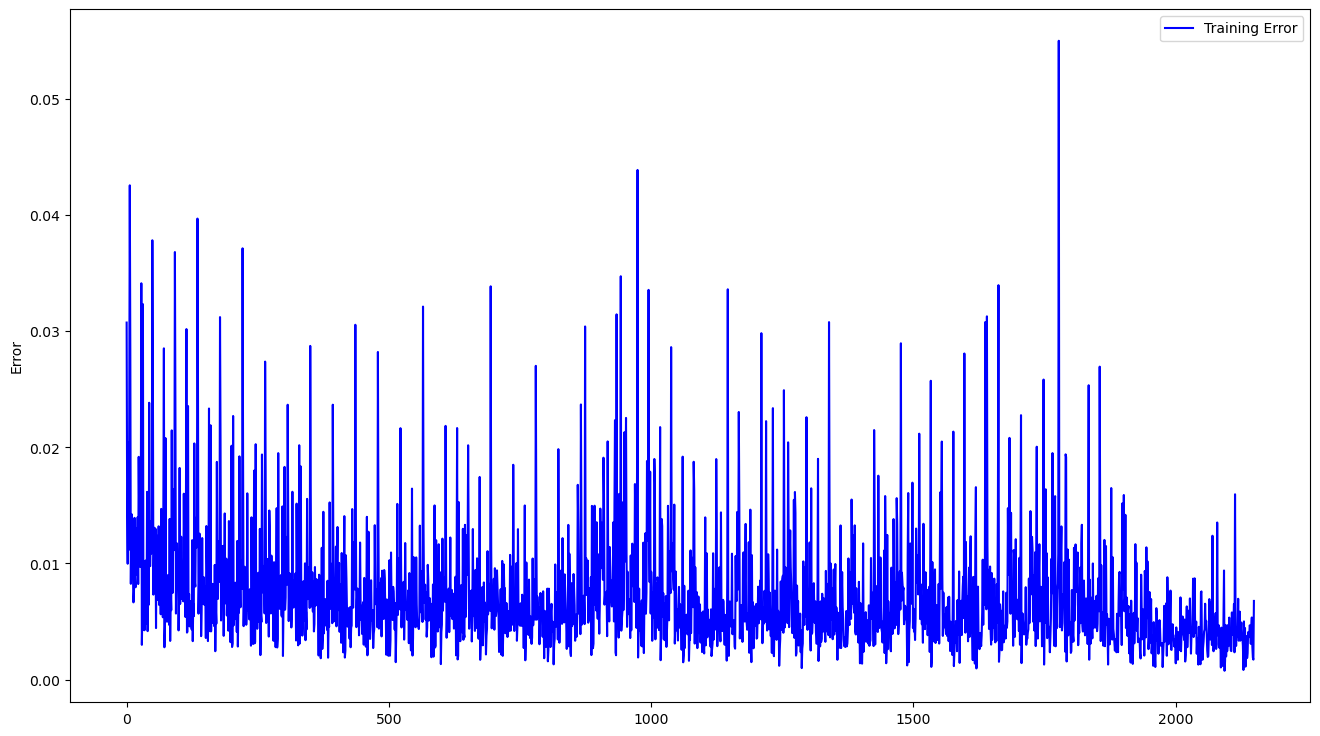

In [45]:
n_epochs = 50

#train model
train_losses = []

model.train()
for e in range(n_epochs):
    for X, y in sessions:
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, 55))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{e+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

Loss: 0.0036826807


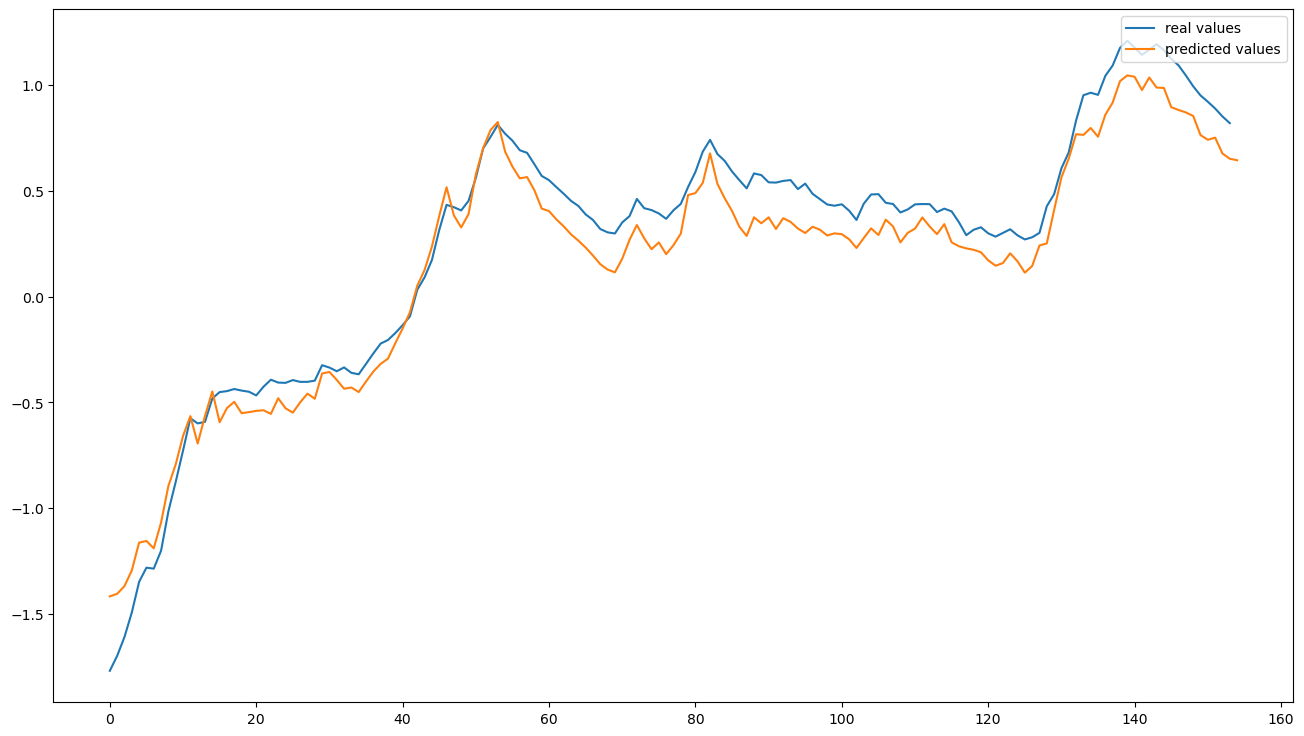

In [46]:
model.eval()

#evaluation on session 80 and 81
session_80 = df_norm[df_norm["profile_id"] == 80]
session_80 = session_80.iloc[:15500]

y = session_80["pm"]
X = session_80.drop(["pm", "profile_id"], axis=1)

X_80 = torch.from_numpy(X.values[:22000, :]).float() 
y_80 = torch.from_numpy(y.values[:22000]).float()

out = model.forward(X_80.view(-1, seq_len, 55))
loss = criterion(out, y_80.view(-1, seq_len, 1))
print("Loss: " + str(loss.detach().numpy()))

out = out[:, -1, :]
pred = out.detach().numpy().flatten()
real = y_80.numpy()[seq_len::seq_len]

plt.plot(real.flatten(), label="real values")
plt.plot(pred, label="predicted values")
plt.legend(loc='upper right')
plt.show()